# Quantitative Trading Strategies
# Return Predictions From Trade Flow

## FINM 33150 - 2024

* Baptiste PEPIN

### Import modules

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

%matplotlib inline

### 1. Introduction

In this project, we will assess trade flow as means of generating profit opportunities in 3 cryptotoken markets. We stress the word “opportunity” because at high data rates like these, and given the markets’ price-time priority, it is far easier to identify desirable trades in the data stream than it is to inject oneself profitably into the fray.

To do so, we will first transform the data to calculate our different variables of interest. We will then implement a strategy to participate in the different trades and calculate the profit and loss generated by our strategy. Finally, we will assess the performance of our strategy and the different parameters that we can tune to improve it.

### 2. Data Loading

The required data has been provided in the form of two datasets for each market: one for trades and one for the order book. The trade data contains the following fields: timestamp, side (buy or sell), price, and size. The order book data contains the following fields: timestamp, bid price, bid size, ask price, ask size and mid price. The data is at nanosecond resolution and spans a period of 24 hours.

The 3 following markets have been selected for this analysis:
* **BTC-USD**
* **ETH-BTC**
* **ETH-USD**

We will first load the data and take a look at the first few rows of each dataset to better understand the structure of the data.

In [2]:
symbols = ['BTC-USD', 'ETH-USD', 'ETH-BTC']

In [3]:
trades_data = {}

for symbol in symbols:
    data = pd.read_csv('./trades_narrow_' + symbol + '_2023.delim.gz', sep='\t')
    data.sort_values('timestamp_utc_nanoseconds', inplace=True)
    trades_data[symbol] = data

In [4]:
trades_data['ETH-BTC'].head()

,received_utc_nanoseconds,timestamp_utc_nanoseconds,PriceMillionths,SizeBillionths,Side
0,1674521345955989000,1674521346020758000,70950,259656510,1
1,1674521345984460000,1674521346050573000,70950,140800,1
2,1674521348097555000,1674521348159815000,70950,53582550,-1
3,1674521352535174000,1674521352601911000,70940,207220,-1
4,1674521546128872000,1674521546201920000,70950,990630,1


In [5]:
book_data = {}

for symbol in symbols:
    data = pd.read_csv('./book_narrow_' + symbol + '_2023.delim.gz', sep='\t')
    data.sort_values('timestamp_utc_nanoseconds', inplace=True)
    book_data[symbol] = data

In [6]:
book_data['ETH-BTC'].head().T

,0,1,2,3,4
Ask1PriceMillionths,7.097000e+04,7.097000e+04,7.097000e+04,7.097000e+04,7.097000e+04
Bid1PriceMillionths,7.094000e+04,7.094000e+04,7.094000e+04,7.094000e+04,7.094000e+04
Ask1SizeBillionths,2.297617e+09,2.297617e+09,2.297617e+09,1.507617e+09,1.507617e+09
Bid1SizeBillionths,4.860384e+07,4.860384e+07,4.860384e+07,4.860384e+07,4.860384e+07
Ask2PriceMillionths,7.098000e+04,7.098000e+04,7.098000e+04,7.098000e+04,7.098000e+04
Bid2PriceMillionths,7.093000e+04,7.093000e+04,7.093000e+04,7.093000e+04,7.093000e+04
Ask2SizeBillionths,1.339960e+10,1.339960e+10,1.339960e+10,1.062960e+10,1.062960e+10
Bid2SizeBillionths,1.420685e+10,1.420685e+10,1.499685e+10,1.499685e+10,1.499685e+10
received_utc_nanoseconds,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18
timestamp_utc_nanoseconds,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18,1.674521e+18


As we can see, the prices are in millionths and the sizes are in billionths. We will transform these values to the usual ones when loading the data and computing our PnL to have a better vision of our performances. The timestamps are in nanoseconds and might not be unique, this is something we will have to take into account when working with our dataframes.

When working with BTC-USD and ETH-USD, we have one leg of the trade that is in USD, and the other in BTC or ETH. So it is just like if we were trading BTC and ETH using an account in USD. On the other hand, when working with ETH-BTC, both legs of the trade are cryptocurrencies. Therefore, we should apply an exchange rate to our PnL to have a better vision of our performances. Since we will mainly be comparing performances within the same market and not between them, we make the choice to assume that we are entering trades on the ETH-BTC market using an account in BTC, so that we do not have to bother with exchange rates. We should just be careful when comparing performances between different markets now.

### 2. Data Transformation & Strategy Implementation

To work on our dataframes and compute the different variables we are interested in, we will create a class. We will also use this class to implement a strategy to participate in the different trades and calculate the profit and loss generated by our strategy.

The `CryptoTradeAnalysis` class is crafted for scrutinizing cryptocurrency trades, facilitating operations ranging from data loading to predictive analyses and profitability assessments. Upon its instantiation, it initializes paths for both trade and book data files contingent on the provided symbol, followed by the loading of these files. The trade data encapsulates timestamps, sides of trades, prices, and sizes, while the book data encompasses timestamps and mid prices.

A notable function, `calcF_tau`, is dedicated to calculating the trade flow $F$ over a defined window of $\tau$ seconds preceding each trade. This calculation involves summing the products of trade sizes and their respective sides (indicating buys or sells) within this timeframe, effectively capturing the net buying or selling pressure leading up to each trade.

Another critical operation, `calcR_T`, focuses on computing returns $r$ for each trade over a future horizon of $T$ seconds. It leverages mid prices from the book data at $T$ seconds post-trade to calculate the return relative to the trade's execution price, providing a measure of the trade's performance over the specified interval.

$$ r_{t + T} = \frac{\text{{price}}_{t + T}}{\text{{price}}_{\text{{t}}}} - 1 $$

For analytical depth, the class employs a regression analysis through `run_regression`, partitioning the data into training and testing subsets. It calculates returns for both, subsequently fitting a linear regression model on the train set, that predicts returns based on the previously calculated trade flow $F$. This model, aiming to establish a predictive relationship between trade flow and subsequent returns, forms the basis for forecasting returns in the test dataset.

$$ \hat{r} = \beta F $$

The `generate_predicted_returns` function applies the beta coefficient derived from the regression to forecast returns in the test data, considering the trade flow. This step will then allow us to form trade strategies based on anticipated market movements.

Finally, `calculate_pnl` computes the profit and loss from trading, taking into account the predicted returns, a threshold for position entry, and a defined position size relative to the trade size. This function meticulously accounts for trading costs, offering a realistic view of net profitability from trading activities.

Overall, the `CryptoTradeAnalysis` class encapsulates a comprehensive methodology for analyzing trade flows' impact on future returns in the cryptocurrency market. It integrates data processing, analytical modeling, and profitability calculations to provide insights that could inform trading strategies.

In [7]:
class CryptoTradeAnalysis:
    def __init__(self, symbol):
        self.filepath = symbol + '_2023.delim.gz'

        self.trades = None
        self.book = None

        self.train = None
        self.test = None

        self.trade_flow_and_returns = None

        self.model = None
        self.beta = None

        self.load_data()

    def load_data(self):
        try:
            trades = pd.read_csv('./trades_narrow_' + self.filepath, delimiter='\t')
            book = pd.read_csv('./book_narrow_' + self.filepath, delimiter='\t')

            trades = trades[['timestamp_utc_nanoseconds', 'Side', 'PriceMillionths', 'SizeBillionths']]
            trades.columns = ['time', 'side', 'price', 'size']
            trades['side'] = np.sign(trades['side'])
            trades['price'] = trades['price'] / 10 ** 6
            trades['size'] = trades['size'] / 10 ** 9

            book = book[['timestamp_utc_nanoseconds', 'Mid']]
            book.columns = ['time', 'mid']
            book['mid'] = book['mid'] / 10 ** 6

            self.trades = trades
            self.book = book

        except Exception as e:
            print(f"An error occurred while loading the data: {e}")

    @staticmethod
    def calcF_tau(trades_table, tau):
        tau_ns = tau * 10 ** 9
        trades_table = trades_table.sort_values('time')

        times = trades_table['time'].values
        sizes = trades_table['size'].values
        sides = trades_table['side'].values

        F_values = np.zeros(len(trades_table))

        for i in range(len(times)):
            start_time = times[i] - tau_ns

            start_index = np.searchsorted(times, start_time, 'left')
            stop_index = np.searchsorted(times, times[i], 'left')

            F_values[i] = np.sum(sizes[start_index:stop_index] * sides[start_index:stop_index])

        trades_table['F'] = F_values

        return trades_table

    @staticmethod
    def calcR_T(trades_table, book_table, T):
        T_ns = T * 10 ** 9

        irreg = book_table[['time', 'mid']]

        forward_ts = trades_table['time'] + T_ns

        def infer_values(wanted_timestamps, data_df, time_col='time'):
            joined_ts = np.unique(np.concatenate((wanted_timestamps, data_df[time_col])))
            joined_ts = np.sort(joined_ts)

            jts = pd.DataFrame({time_col: joined_ts})
            joined_with_NA = pd.merge(jts, data_df, on=time_col, how='left').sort_values(by=time_col)
            joined_with_NA.ffill(inplace=True)

            wanted = pd.DataFrame({time_col: wanted_timestamps})
            wanted_values = pd.merge(wanted, joined_with_NA, on=time_col, how='left').sort_values(by=time_col)
            return wanted_values

        price_at_reference_ts = infer_values(forward_ts, irreg, 'time')['mid']

        trades_table['r'] = price_at_reference_ts.values / trades_table['price'] - 1
        trades_table['forward_price_T'] = price_at_reference_ts.values

        return trades_table

    def calculate_trade_flow(self, tau_seconds):
        self.trade_flow_and_returns = self.trades.copy()
        self.trade_flow_and_returns = self.calcF_tau(self.trade_flow_and_returns, tau_seconds)

    def calculate_returns(self, T_seconds):
        self.train = self.calcR_T(self.train, self.book, T_seconds)
        self.test = self.calcR_T(self.test, self.book, T_seconds)

    def run_regression(self, T_seconds, train_size):
        n_total = len(self.trade_flow_and_returns)
        n_train = round(n_total * train_size)

        self.train = self.trade_flow_and_returns.iloc[:n_train]
        self.test = self.trade_flow_and_returns.iloc[n_train:]

        self.calculate_returns(T_seconds)

        self.model = sm.ols('r ~ F + 0', data=self.train).fit()
        self.beta = self.model.params['F']

    def generate_predicted_returns(self):
        self.test['predicted_r'] = self.beta * self.test['F']

    def calculate_pnl(self, j, percentage_size_position, trading_cost=0.00001):
        self.test['position'] = np.where(abs(self.test['predicted_r']) > j,
                                         np.sign(abs(self.test['predicted_r'])) * self.test[
                                             'size'] * percentage_size_position, 0)

        self.test['pnl_on_trade'] = self.test['position'] * (self.test['forward_price_T'] - self.test['price'])
        self.test['cum_pnl'] = self.test['pnl_on_trade'].cumsum()

        if trading_cost is not None:
            self.test['net_pnl_on_trade'] = self.test['pnl_on_trade'] - trading_cost * self.test['position'] * \
                                            self.test['price']
            self.test['cum_net_pnl'] = self.test['net_pnl_on_trade'].cumsum()

    def run(self, tau_seconds=20, T_seconds=60, train_size=0.4, j=10 ** (-6), percentage_size_position=0.05, trading_cost=0.00001):
        self.calculate_trade_flow(tau_seconds)
        self.run_regression(T_seconds, train_size)
        self.generate_predicted_returns()
        self.calculate_pnl(j, percentage_size_position, trading_cost)

In [8]:
example = CryptoTradeAnalysis('BTC-USD')
example.run()
trade_analysis = example.test

trade_analysis['time'] = pd.to_datetime(trade_analysis['time'])
trade_analysis.set_index('time', inplace=True)
trade_analysis.head()

,side,price,size,F,r,forward_price_T,predicted_r,position,pnl_on_trade,cum_pnl,net_pnl_on_trade,cum_net_pnl
time,,,,,,,,,,,,
2023-01-24 15:36:52.120067,-1,22866.60,0.023759,3.532754,0.000167,22870.415,0.000007,0.001188,0.004532,0.004532,0.004260,0.004260
2023-01-24 15:36:52.120067,-1,22865.77,0.011389,3.532754,0.000203,22870.415,0.000007,0.000569,0.002645,0.007177,0.002515,0.006775
2023-01-24 15:36:52.120067,-1,22865.78,0.142124,3.532754,0.000203,22870.415,0.000007,0.007106,0.032937,0.040114,0.031312,0.038087
2023-01-24 15:36:52.120067,-1,22866.57,0.012585,3.532754,0.000168,22870.415,0.000007,0.000629,0.002419,0.042534,0.002276,0.040363
2023-01-24 15:36:52.535857,1,22866.08,0.001111,4.059136,0.000208,22870.825,0.000009,0.000056,0.000263,0.042797,0.000251,0.040614


In [9]:
def plot_cumulative_pnl_returns(data, title, j):
    sns.set(style="whitegrid")
    f, axes = plt.subplots(1, 2, figsize=(15, 5))

    percentage_participated_trades = (data['position'] != 0).sum() / data['position'].count()
    print(f'Percentage of our participation in all the trades: {percentage_participated_trades:.2%}')
    display(data.tail())

    data = data.groupby('time').last().reset_index()
    data['time'] = pd.to_datetime(data['time'])

    try:
        sns.lineplot(x='time', y='cum_net_pnl', data=data, ax=axes[0], color='green', label='Net Cumulative PnL')
        sns.lineplot(x='time', y='cum_pnl', data=data, ax=axes[0], color='blue', label='Cumulative PnL')
        axes[0].set_title('Cumulative PnL')
    except KeyError:
        sns.lineplot(x='time', y='cum_pnl', data=data, ax=axes[0], color='green')
        axes[0].set_title('Cumulative PnL')

    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('PnL')

    sns.lineplot(x='time', y='predicted_r', data=data, ax=axes[1], color='blue', label='Predicted Forward Returns')

    twin_ax = axes[1].twinx()
    twin_ax.plot(data['time'], data['r'], color='red', label='Realized Forward Returns')

    axes[1].axhline(y=j, color='red')
    axes[1].axhline(y=-j, color='red')

    axes[1].set_title('Returns')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Predicted Returns')
    twin_ax.set_ylabel('Realized Returns')

    handles1, labels1 = axes[1].get_legend_handles_labels()
    handles2, labels2 = twin_ax.get_legend_handles_labels()

    handles = handles1 + handles2
    labels = labels1 + labels2

    axes[1].legend(handles, labels)

    for ax in axes:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

Percentage of our participation in all the trades: 86.64%


,side,price,size,F,r,forward_price_T,predicted_r,position,pnl_on_trade,cum_pnl,net_pnl_on_trade,cum_net_pnl
time,,,,,,,,,,,,
2023-01-25 15:50:01.477570,1,22573.08,0.000921,-0.125152,-0.000110,22570.605,-2.636511e-07,0.00000,-0.000000,6241.856966,-0.000000,5985.886082
2023-01-25 15:50:01.543105,-1,22571.97,0.335000,-0.124231,-0.000060,22570.605,-2.617114e-07,0.00000,-0.000000,6241.856966,-0.000000,5985.886082
2023-01-25 15:50:01.601688,-1,22570.92,0.050000,-0.459231,-0.000014,22570.605,-9.674386e-07,0.00000,-0.000000,6241.856966,-0.000000,5985.886082
2023-01-25 15:50:01.601719,-1,22570.92,0.032600,-0.509231,-0.000014,22570.605,-1.072771e-06,0.00163,-0.000513,6241.856452,-0.000881,5985.885201
2023-01-25 15:50:01.601767,-1,22570.92,0.006010,-0.541831,-0.000014,22570.605,-1.141448e-06,0.00030,-0.000095,6241.856358,-0.000162,5985.885038


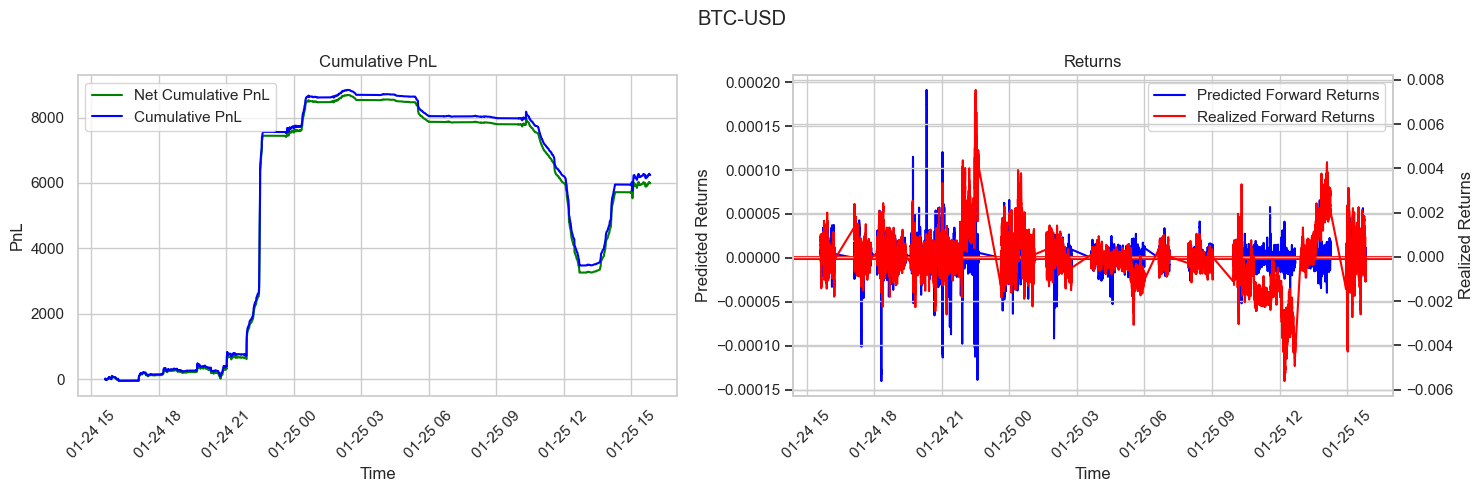

In [10]:
plot_cumulative_pnl_returns(trade_analysis, 'BTC-USD', j=10 ** (-6))

Here are the results of our example using the BTC-USD market. We can see that our strategy is participating in about 75% of the trades. This means that our threshold j is not too high and allows us to participate frequently in the trades. We can also see that our strategy is generating a positive cumulative PnL of approximately 6000 dollars. This is a good sign that our strategy is working well. Here we are working with a $\tau$ of 10 seconds and a $T$ of 60 seconds. We are also using 40% of our data for training and 60% for testing. We are using a threshold j of $10^{-6}$ and a proportion size of 5% of the trade size for our positions. We are also taking into account a trading cost of 0.001% of the trade size. On the right side, we also compute the predicted returns and compare them to our threshold j. It also shows the realized forward returns as a way to compare with our calculated ones. We can see that our predicted returns are not too far from our realized returns.

We are making a certain number of assumptions on what is going to follow. For calculating our cumulative PnL, for each trade we participate in, we get a position that we can multiply with the difference of the price of the trade we are participating in and the mid price we will close that same position T seconds later. Since T is small, no more than one minute, we consider the entire PnL of the position as soon as we open it, this simplifies our calculations and allow us to vectorize. In a more realistic setting, we should compute the cumulative PnL along the life of our T-seconds trade, but this is not going to change a lot of things for us here.

In [11]:
beta = example.beta
print(f'Our beta coefficient is: {beta:.2e}')

Our beta coefficient is: 2.11e-06


Our beta coefficient here is of the order of $10^{-6}$. This means that for each unit of trade flow, we can expect a return of $10^{-6}$. Our threshold $j$ is also of the order of $10^{-6}$ by choice here so in other words, we are expecting to enter a trade when the trade flow value is above 1 or below -1.

### 3. Parameter Tuning

As we saw before, we are working with different chosen parameters. This part aims to explore different values of our parameters. While we should explore different values of all of them at the same time, for the sake of simplicity in our analysis, we will explore them one by one and then we will try to optimize our strategy by running an optimisation on all of the parameters at the same time. Let's start by exploring different values of:
* $j$: the threshold for entering a trade, compared to our predicted returns
* $\tau$: the window of time we are considering for our trade flow calculation
* $T$: the window of time we are considering for our forward returns calculation

We will then try to look at $\beta$ and see how stable it is, but also at some variation of the training size of our data.

In [12]:
# We load the different markets into different objects

BTCUSD = CryptoTradeAnalysis('BTC-USD')
ETHUSD = CryptoTradeAnalysis('ETH-USD')
ETHBTC = CryptoTradeAnalysis('ETH-BTC')

In [13]:
# We define different functions to explore the values of our parameters

def run_strategy_varying_j(strategy, j_values):
    results_j = {}
    for j in j_values:
        strategy.run(j=j)
        results_j[j] = strategy.test
    return results_j


def run_strategy_varying_T(strategy, T_values):
    results_T = {}
    for T in T_values:
        strategy.run(T_seconds=T)
        results_T[T] = strategy.test
    return results_T


def run_strategy_varying_tau(strategy, tau_values):
    results_tau = {}
    for tau in tau_values:
        strategy.run(tau_seconds=tau)
        results_tau[tau] = strategy.test
    return results_tau

In [14]:
# We define the ranges of parameters

j_values = [10 ** (-7), 10 ** (-6), 10 ** (-5), 10 ** (-4)]
T_values = [1, 5, 10, 20, 60, 120]  # in seconds
tau_values = [1, 5, 10, 20, 30, 60]  # in seconds

Now that we have defined the ranges of our parameters, we can run our strategies and explore the different values. We store each strategy in a dictionary to access it later.

In [15]:
results_j_BTCUSD = run_strategy_varying_j(BTCUSD, j_values)
results_T_BTCUSD = run_strategy_varying_T(BTCUSD, T_values)
results_tau_BTCUSD = run_strategy_varying_tau(BTCUSD, tau_values)

In [16]:
results_j_ETHUSD = run_strategy_varying_j(ETHUSD, j_values)
results_T_ETHUSD = run_strategy_varying_T(ETHUSD, T_values)
results_tau_ETHUSD = run_strategy_varying_tau(ETHUSD, tau_values)

In [17]:
results_j_ETHBTC = run_strategy_varying_j(ETHBTC, j_values)
results_T_ETHBTC = run_strategy_varying_T(ETHBTC, T_values)
results_tau_ETHBTC = run_strategy_varying_tau(ETHBTC, tau_values)

In [18]:
def plot_cumulative_pnl_for_strategy_var(strategy_BTC_USD, strategy_ETH_USD, strategy_ETH_BTC, title, var, train_size=False):
    sns.set(style="whitegrid")
    custom_palette = ['green', 'blue', 'purple', 'red', 'orange']
    sns.set_palette(custom_palette)

    f, axes = plt.subplots(3, 2, figsize=(15, 18))

    strategies_variants = [strategy_BTC_USD, strategy_ETH_USD, strategy_ETH_BTC]
    strategy_labels = ['BTC-USD', 'ETH-USD', 'ETH-BTC']

    participation_df = pd.DataFrame(columns=strategy_labels)
    participation_df.index.name = f'Values of {var}'

    for i, (strategy_data, strategy_label) in enumerate(zip(strategies_variants, strategy_labels)):
        pnl_ax = axes[i][0]
        price_ax = axes[i][1]

        for variant_label, data in strategy_data.items():
            percentage_participated_trades = (data['position'] != 0).sum() / data['position'].count()

            if variant_label not in participation_df.index:
                participation_df.loc[variant_label] = [None] * len(strategy_labels)
            participation_df.at[variant_label, strategy_label] = percentage_participated_trades

            data = data.groupby('time').last().reset_index()
            data['time'] = pd.to_datetime(data['time'])

            try:
                sns.lineplot(x='time', y='cum_net_pnl', data=data, ax=pnl_ax, label=variant_label)
            except KeyError:
                sns.lineplot(x='time', y='cum_pnl', data=data, ax=pnl_ax, label=variant_label)

            # Set PnL plot title and labels
            pnl_ax.set_title(f'Cumulative Realized PnL for {strategy_label}')
            pnl_ax.set_xlabel('Time')
            pnl_ax.set_ylabel('PnL')
            pnl_ax.legend(title=f'Value of {var}')
            pnl_ax.tick_params(axis='x', rotation=45)
        
            if train_size:
                sns.lineplot(x='time', y='price', data=data, ax=price_ax, color='black')
                
        
        sns.lineplot(x='time', y='price', data=data, ax=price_ax, color='black', label='Price')
        sns.lineplot()

        price_ax.set_title(f'Price for {strategy_label}')
        price_ax.set_xlabel('Time')
        price_ax.set_ylabel('Price')
        price_ax.legend()
        price_ax.tick_params(axis='x', rotation=45)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    display(participation_df)

    return participation_df

#### 3.1. Varying the threshold j

We will start by exploring different values of the threshold $j$ for entering a trade. Making $j$ smaller will allow us to participate in more trades, but it will also increase the number of false positives. While making $j$ bigger will allow us to participate in less trades.

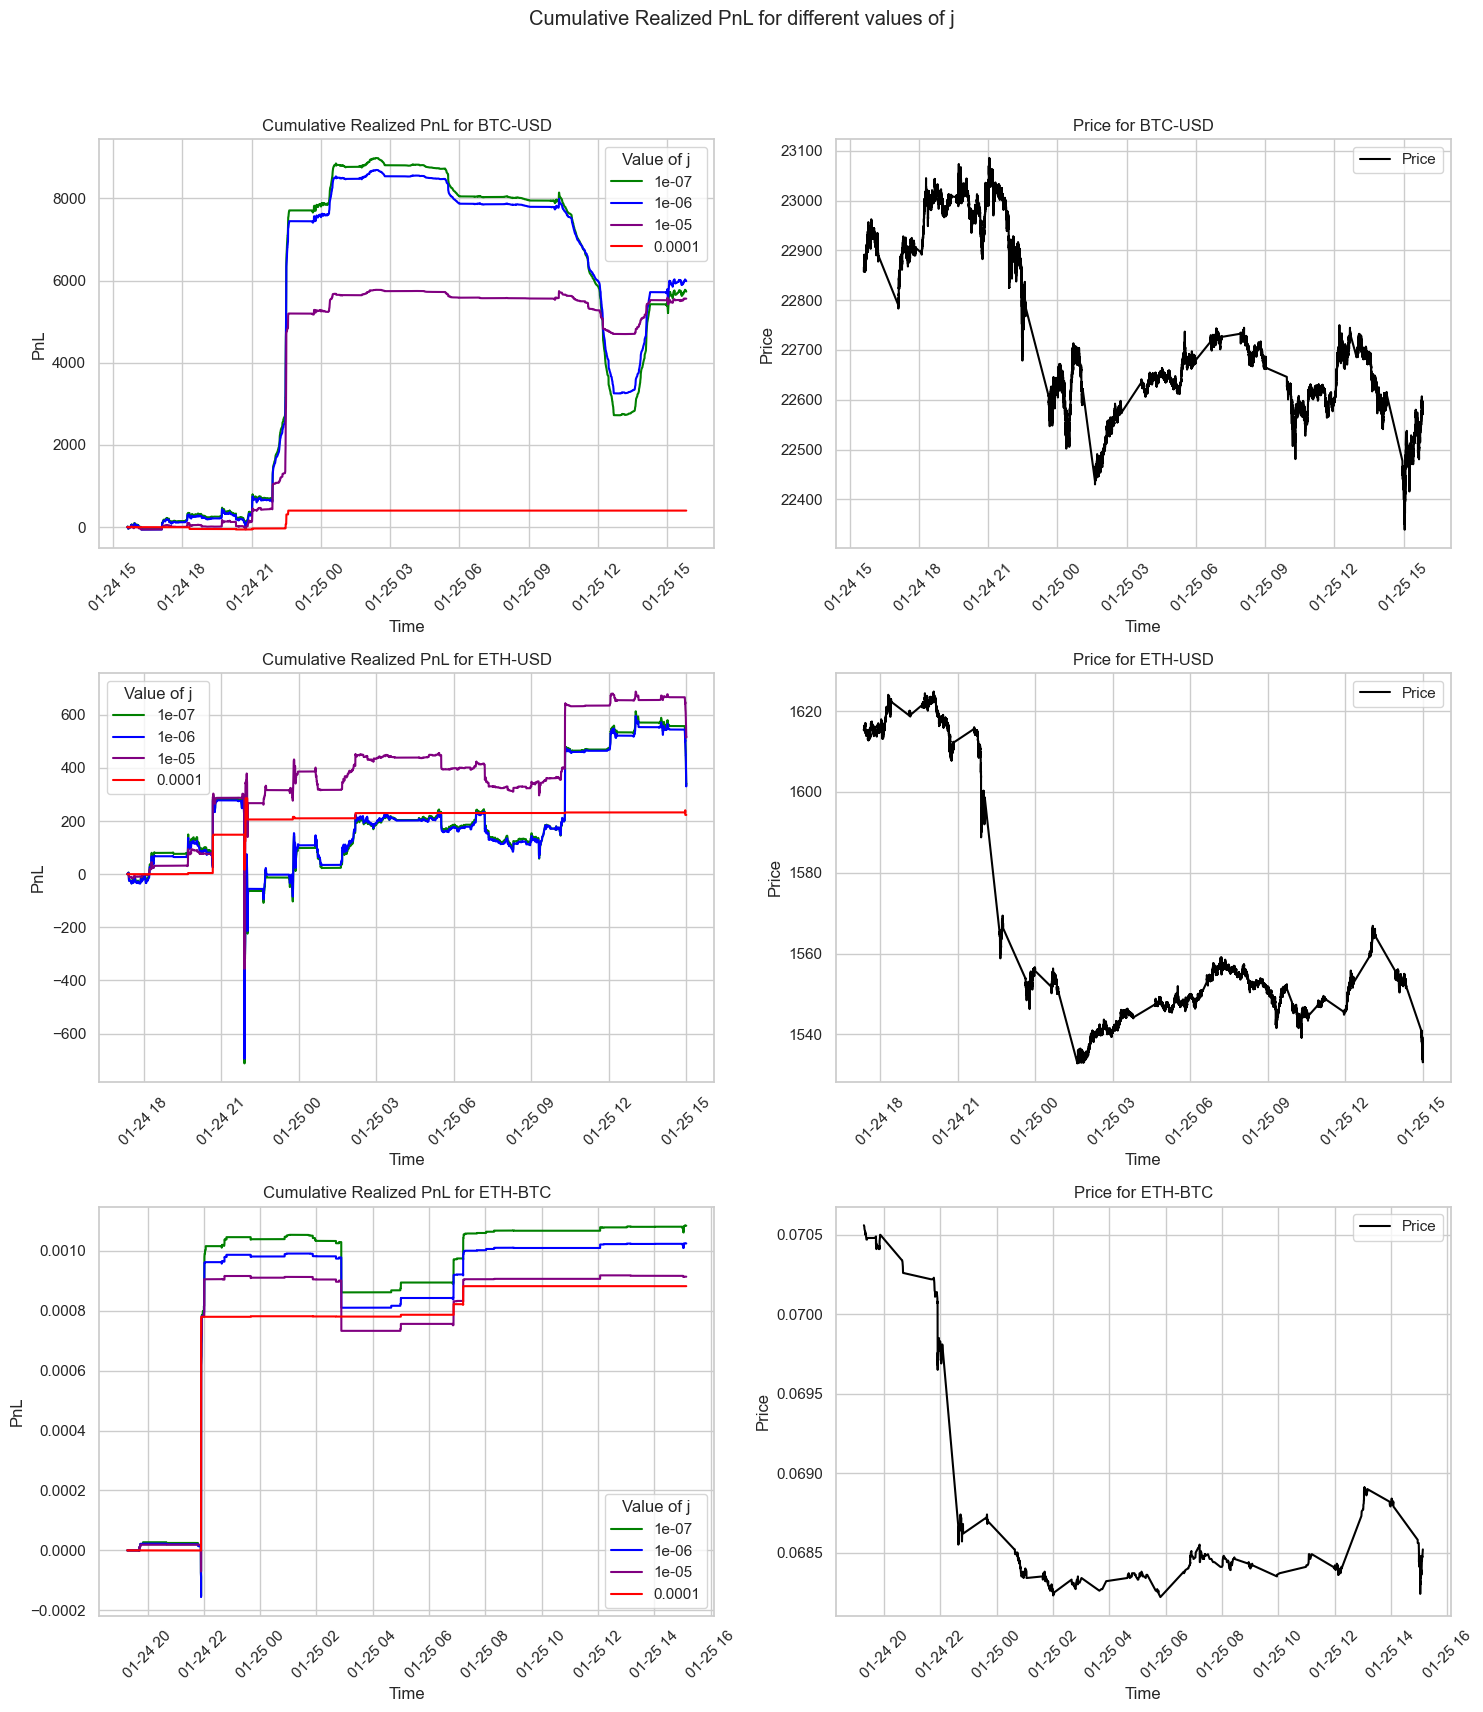

,BTC-USD,ETH-USD,ETH-BTC
Values of j,,,
1.000000e-07,0.985533,0.988653,0.678298
1.000000e-06,0.86643,0.891786,0.502128
1.000000e-05,0.25851,0.344963,0.304681
1.000000e-04,0.005255,0.012302,0.138723


In [19]:
j_var = plot_cumulative_pnl_for_strategy_var(results_j_BTCUSD, results_j_ETHUSD, results_j_ETHBTC,
                                             'Cumulative Realized PnL for different values of j', 'j')

Looking at the graphs first, it appears that the lower our threshold $j$, the higher our cumulative PnL. This is not surprising as we are participating in more trades. Below $10^{-5}$, we do not trade anymore or very little, which causes our cumulative PnL to be null or at least to stay flat around 0.

As we can see, in order to reach some good level of participation in the different trades, our threshold $j$ should be of the order of $10^{-6}$ for the BTC-USD and ETH-USD markets (around 70 to 80 percent participation). Let's not forget that those values are adapted for the default windows we are working with, namely: $\tau = 20$ seconds and $T = 60$ seconds.
 
For the ETH-BTC market, we can see that we are participating in very little trades. If we look at the data for that market, we can see that there are much fewer movements and this has an impact on our trade flow calculation but also forwards returns as we will see later. If we just plot our predicted returns, we see that a lot of them are null, probably due to the fact that our calculation windows are not adapted.

Percentage of our participation in all the trades: 50.21%


,time,side,price,size,F,r,forward_price_T,predicted_r,position,pnl_on_trade,cum_pnl,net_pnl_on_trade,cum_net_pnl
1953,1674659220556309000,-1,0.06847,0.000171,0.000000,-0.000073,0.068465,0.000000e+00,0.0,-0.0,0.00105,-0.0,0.001025
1954,1674659233932491000,-1,0.06848,0.083190,-0.000171,0.000000,0.068480,-6.254356e-10,0.0,0.0,0.00105,0.0,0.001025
1955,1674659254076843000,1,0.06849,0.077766,0.000000,-0.000365,0.068465,0.000000e+00,0.0,-0.0,0.00105,-0.0,0.001025
1956,1674659254810416000,-1,0.06850,0.032440,0.077766,-0.000584,0.068460,2.846971e-07,0.0,-0.0,0.00105,-0.0,0.001025
1957,1674659285145749000,1,0.06852,1.266989,0.000000,-0.000876,0.068460,0.000000e+00,0.0,-0.0,0.00105,-0.0,0.001025


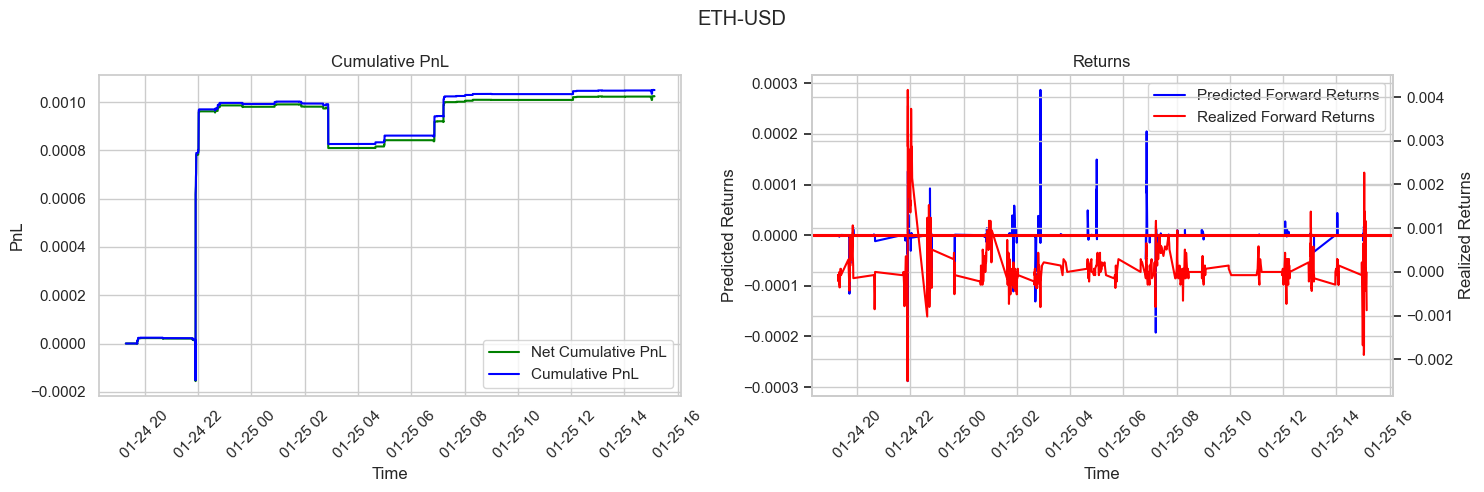

In [20]:
plot_cumulative_pnl_returns(results_j_ETHBTC[10 ** (-6)], 'ETH-USD', j=10 ** (-6))

#### 3.2. Varying the window of time $\tau$

Another parameter we could try to modify is the trade flow calculation window $\tau$. In fact, if we work with windows that are too small, we might get a lot of trade flow values that are null, which could cause our regression model to be less efficient, and therefore our beta would not be a good predictor coefficient for our forwards returns. Also, those forwards returns would be mainly null if the trade flow is null again. This emphasizes the importance ofchoosing windows that are adapted to the market we are working with.

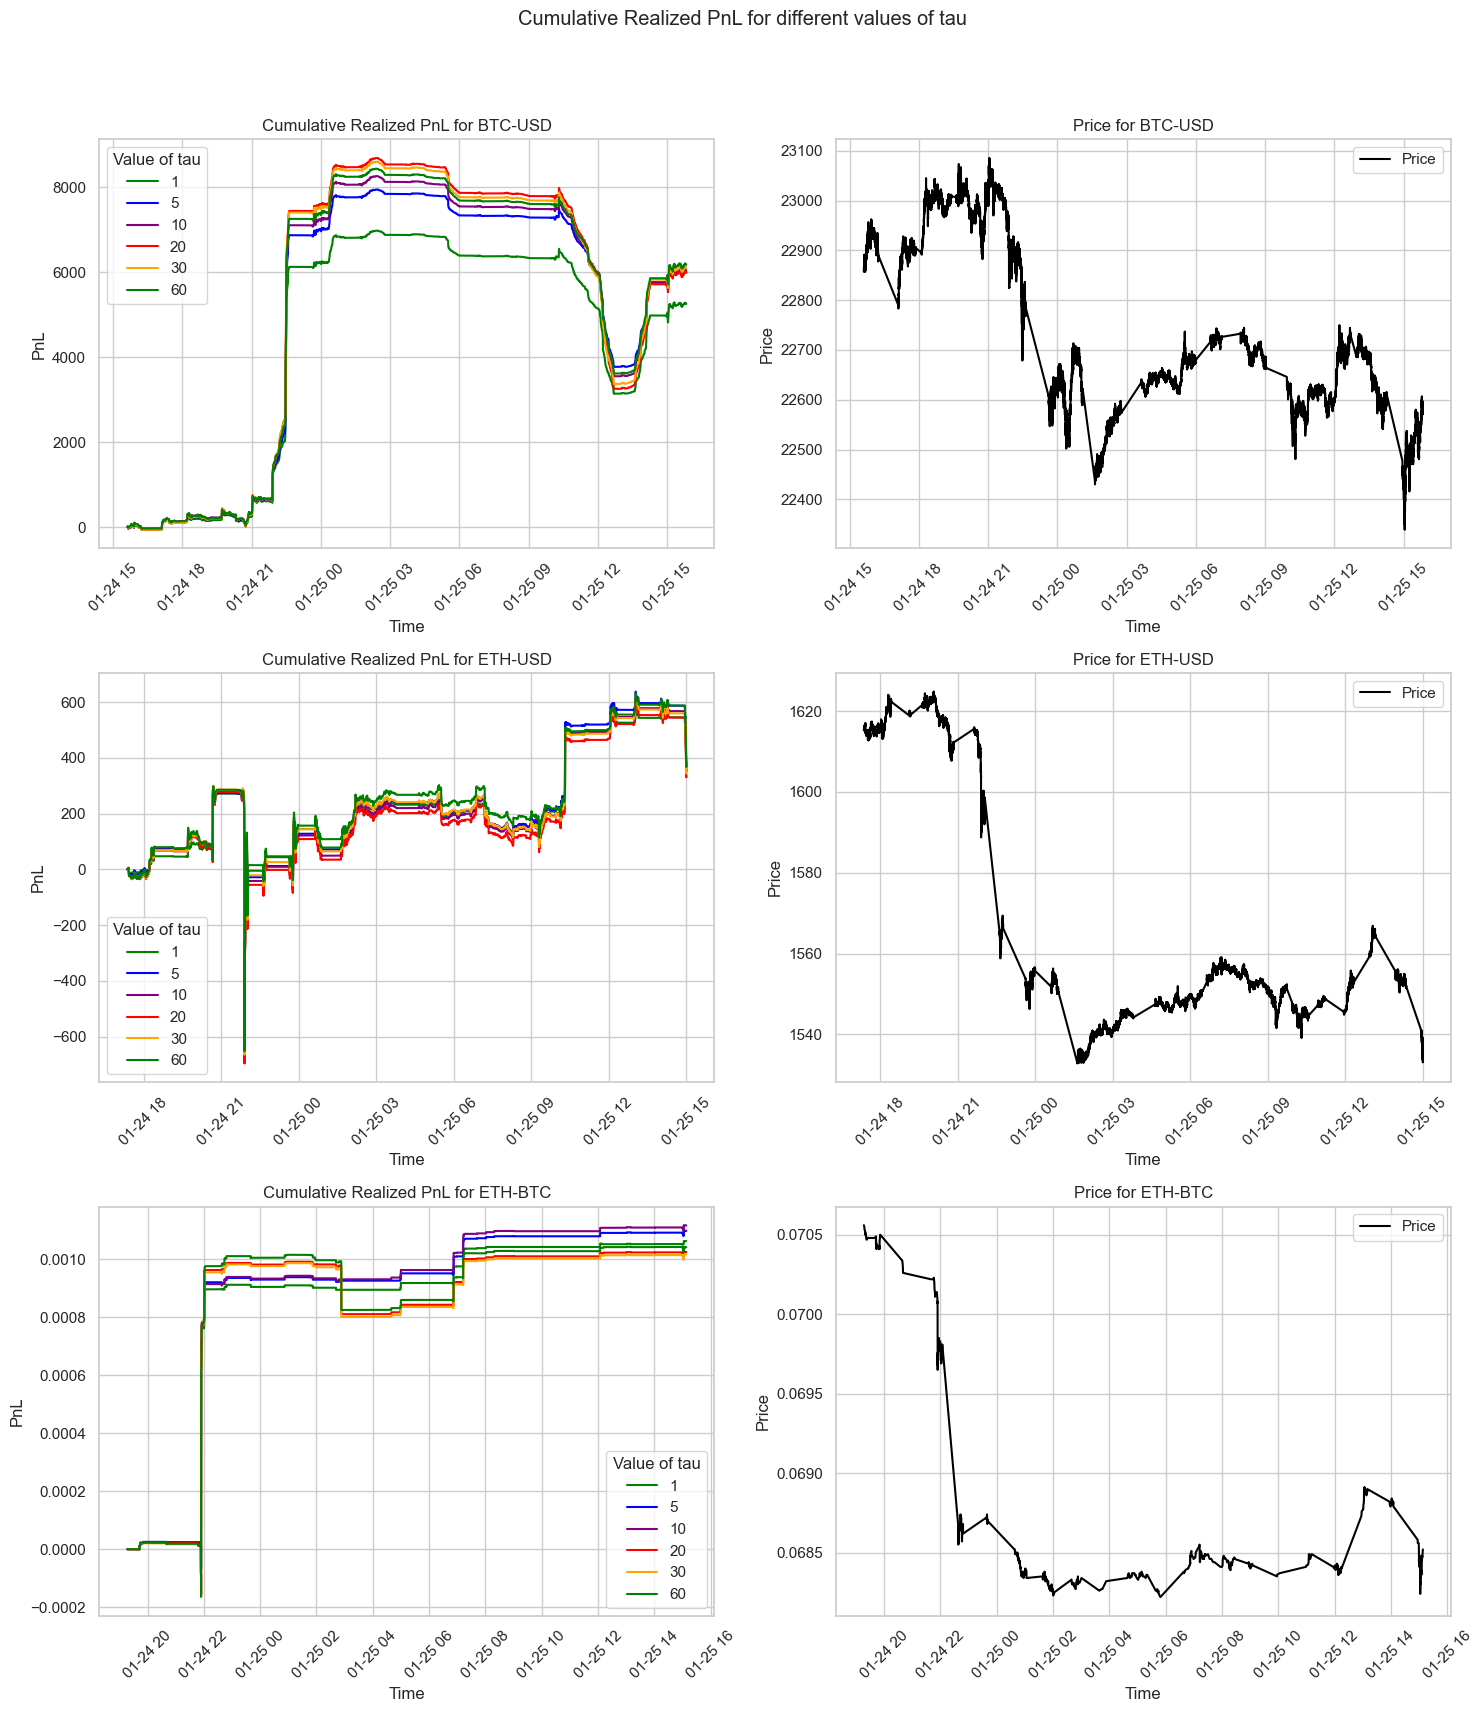

,BTC-USD,ETH-USD,ETH-BTC
Values of tau,,,
1,0.523656,0.361087,0.335319
5,0.635123,0.745465,0.389787
10,0.751884,0.844921,0.442553
20,0.86643,0.891786,0.502128
30,0.871852,0.908891,0.558298
60,0.82298,0.901211,0.617021


In [21]:
tau_var = plot_cumulative_pnl_for_strategy_var(results_tau_BTCUSD, results_tau_ETHUSD, results_tau_ETHBTC,
                                               'Cumulative Realized PnL for different values of tau', 'tau')

As could have been excepted, the smaller the window $\tau$, the less we are participating in the trades. This is because we are capturing fewer movements in the market: here it means we are accumulating fewer trades for the flow, and therefore we have more null values that causes our predicted returns ($\beta \times F$) to be null too.

However, we can see that the cumulative PnL is not necessarily better when we have larger windows that allow us to trade more. This is because we are also capturing more noise in the market. Shorter windows in that sense would be able to capture the most important movements from which we profit.

We can see that for the BTC-USD and ETH-USD markets, a window of 10 seconds is a good compromise. For the ETH-BTC market, we can see that a window of 5 seconds is a good compromise, again we need to adapt to the market to get a parameter that would give us a high participation rate in the trades.

#### 3.3. Varying the window of time $T$

We can also try to vary the window of time $T$ for our forward returns calculation. The consequences of doing so are multiple. The first is that we are betting on returns on a shorter period of time. It means that our trades have 'value' in terms of the time they are running, that is lower. Therefore, we might catch less movement but we are also probably less exposed. This is something we will have to look at when comparing the tail risks of our different strategies.

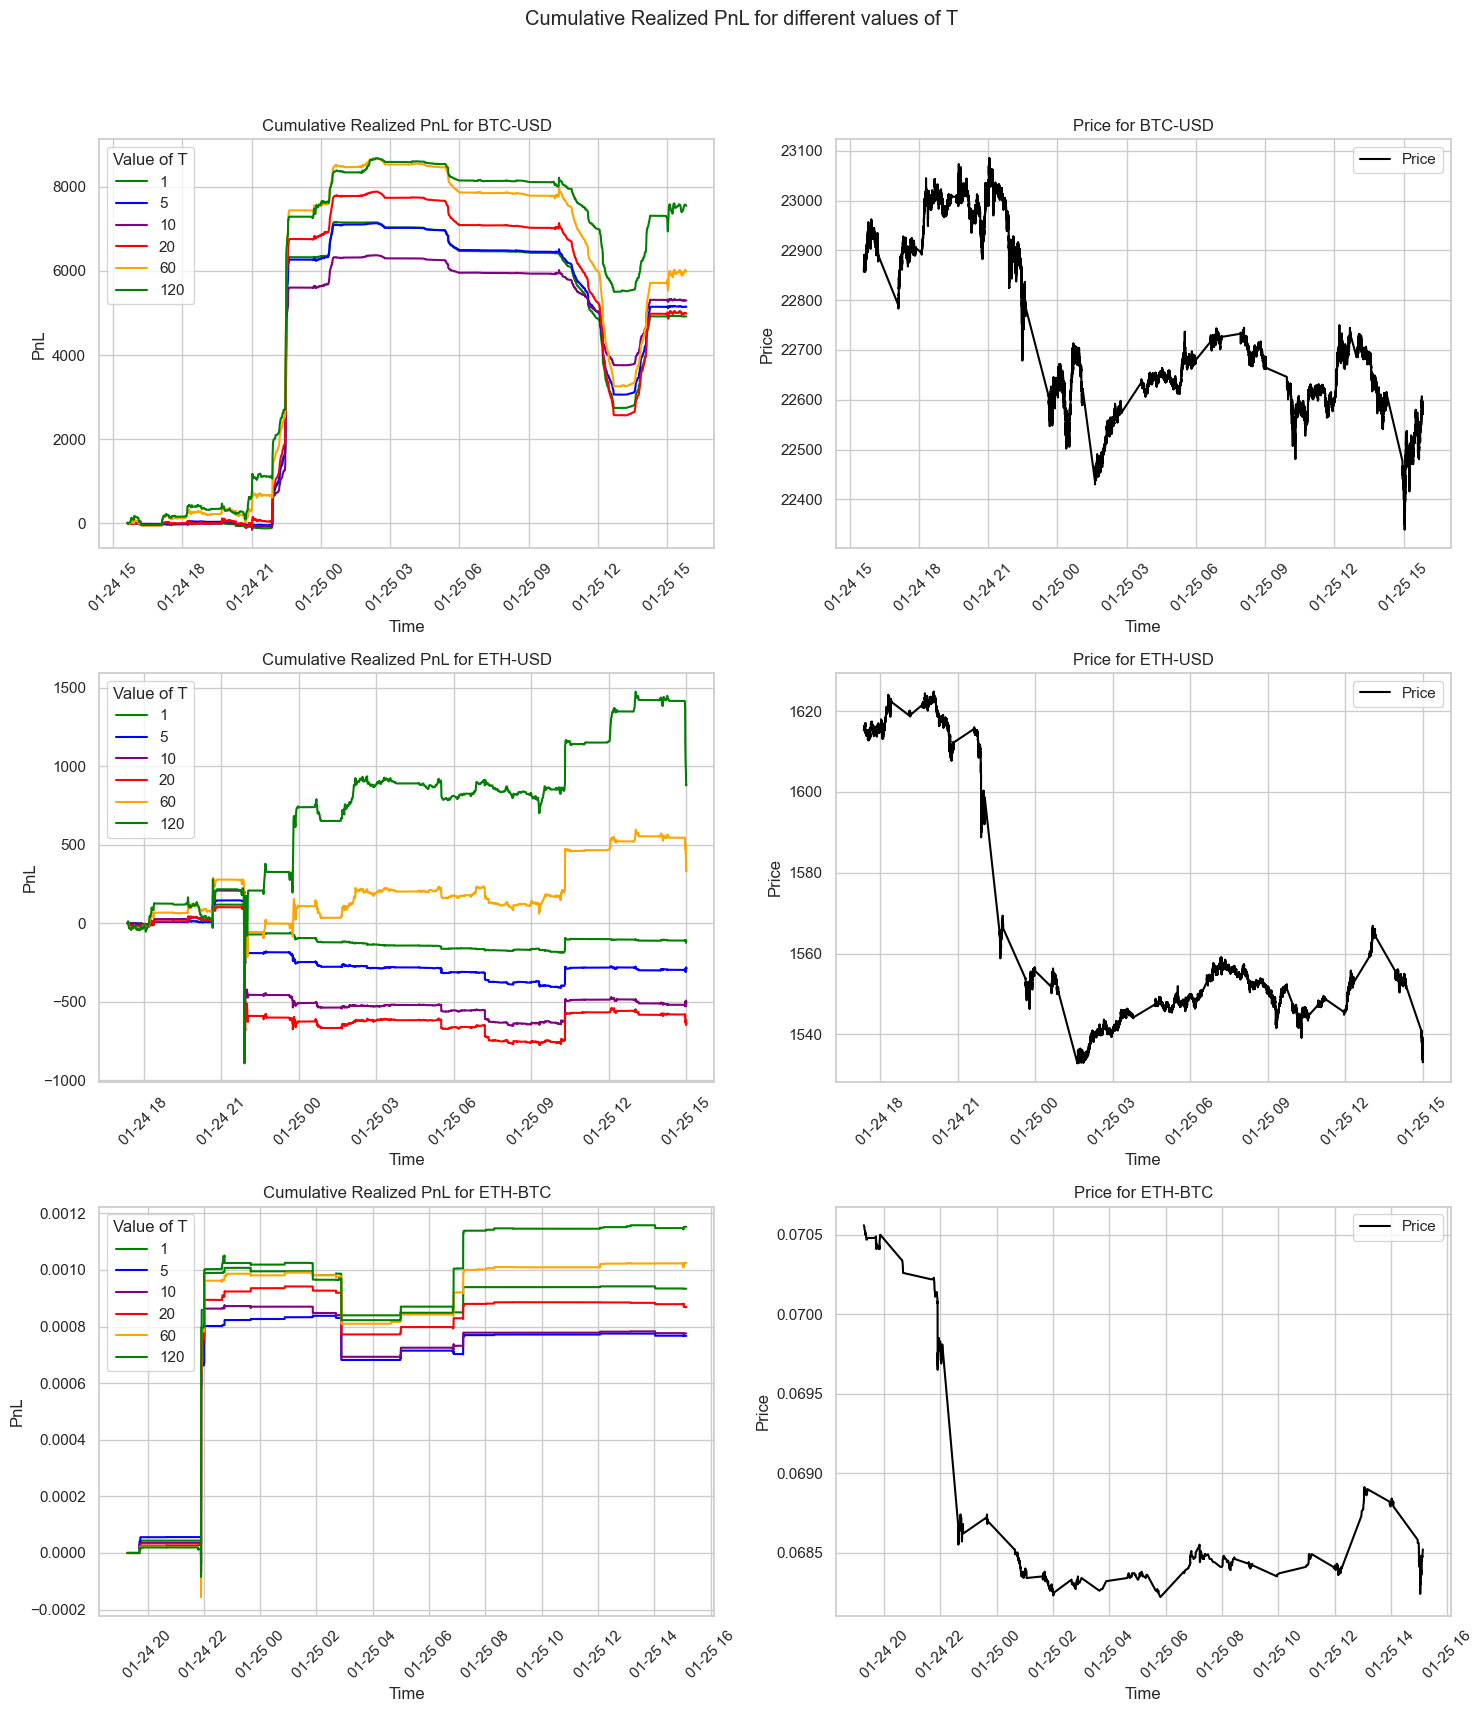

,BTC-USD,ETH-USD,ETH-BTC
Values of T,,,
1,0.727341,0.769313,0.267234
5,0.690764,0.851841,0.36
10,0.493061,0.857276,0.278298
20,0.839295,0.860126,0.406809
60,0.86643,0.891786,0.502128
120,0.570814,0.926517,0.425532


In [22]:
T_var = plot_cumulative_pnl_for_strategy_var(results_T_BTCUSD, results_T_ETHUSD, results_T_ETHBTC,
                                     'Cumulative Realized PnL for different values of T', 'T')

Again, if we look at the participation rate in the trades, we can see that the bigger the window $T$, the more we are participating in the trades. This is because we are capturing more movements in the market. The graphs also show some results similar to the one we observed for varying $j$ which is consistent with the fact that they both have an impact on the forward returns we are predicting and the way we use them to enter trades.

Looking more closely at the graphs, it appears that they have very different shapes. In fact, even the order of performance of the different values of $T$ is not the same for the different markets. Except for $T=60$ or $T=120$ seconds, which is the best parameter on all the markets. Maybe we could see here a 'structural' behavior in the sense of that investors are placing their trades on a regular basis, and using one-minute window in our model could capture such behavior.

Nevertheless, we can see that using a window of 60 seconds is a good compromise for all the markets. It allows us to participate in a good number of trades and to capture a good number of movements in the market. This is also consistent with the fact that we are using a smaller window of 20 seconds for our trade flow calculation. We are using the trade flow to predict returns on a window of 60 seconds, which is a good compromise. All the strategies have positive cumulative PnL with this choice of parameter, while for lower values of $T$, we can see that the cumulative PnL on ETH-USD is negative.

#### 3.4. Optimization - Optuna

We have explored different values of our parameters and we have seen that they have an impact on our strategy. We have also seen that the different markets have different behaviors and that we should adapt our parameters to the market we are working with. We will now try to optimize our strategy by running an optimization on all of the parameters at the same time. We will use the Optuna library to do so.

In [ ]:
analysis = CryptoTradeAnalysis("XXX-XXX")

def objective(trial):
    tau_seconds = trial.suggest_int('tau_seconds', 5, 60)
    T_seconds = trial.suggest_int('T_seconds', tau_seconds, 180)
    j = trial.suggest_float('j', 1e-7, 1e-5)
        
    analysis.run(tau_seconds=tau_seconds, T_seconds=T_seconds, j=j)
    
    profit = analysis.test['cum_net_pnl'].iloc[-1]
    return profit

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

# print(f"Best parameters: {study.best_params}")
# print(f"Best profit: {-study.best_value}")

This notebook explores the parameters individually, but it would have been interesting and very insightful to see how those parameters move together. An optimization using Optuna could have shown some combination of parameters that we might not have explored and that present better performances. Unfortunately, by lack of time, this part has not been implemented.

### 4. Regression parameters

Our regression is supposed to give us a $\beta$ coefficient that we can use to predict our forward returns. Let's have a closer look at the beta for different strategies and see how stable it is by varying the training size of our data. For the other parameters, we will choose those identifies earlier as the 'best' ones for our strategy. We do not change the parameters for ETH-BTC in order to be able to compare the beta coefficients between the different markets.

In [24]:
train_sizes = np.linspace(0.1, 0.9, 9)

beta_df = pd.DataFrame(index=train_sizes, columns=symbols)

tau_seconds = 20
T_seconds = 60
j = 1e-6

for symbol in symbols:
    analysis = CryptoTradeAnalysis(symbol)
    for train_size in train_sizes:
        analysis.run(tau_seconds=tau_seconds, T_seconds=T_seconds, train_size=train_size, j=j)
        beta_df.loc[train_size, symbol] = analysis.beta

In [25]:
beta_df.style.format("{:.2e}").format_index("{:.0%}").set_caption("Beta coefficients for different training sizes")

,BTC-USD,ETH-USD,ETH-BTC
10%,6.31e-06,2.09e-06,3.39e-06
20%,3.66e-06,-1.02e-06,3.18e-06
30%,1.94e-06,-1.03e-06,3.70e-06
40%,2.11e-06,-3.26e-07,3.66e-06
50%,2.63e-06,-7.48e-08,-8.94e-06
60%,2.37e-06,2.63e-07,-1.29e-05
70%,-3.71e-06,2.75e-07,-1.26e-05
80%,-3.84e-06,2.47e-07,-1.18e-05
90%,-4.49e-06,2.18e-07,-1.05e-05


Depending on the markets, we get different behaviors. For BTC-USD, it appears that the beta coefficient is quite stable around $10^{-6}$ for different training sizes. The only remarkable thing here is the fact that beta gets negative for the largest training size. This is a sign that we are overfitting our model, which makes sense since we are fitting on more than 79% of our data.

For ETH-USD, we can see that the beta coefficient is also quite stable around $10^{-6}$ for different training sizes. This is also a good sign that our model is stable and that we are not overfitting. The same behavior as the one observed for BTC-USD appears when we get to larger training sizes, beta gets negative but again, this is a sign that we are overfitting our model, by using more than 50% of our data on the training set.

Finally, for ETH-BTC, the results are less consistent. We get a positive beta of the order of $10^{-6}$ for 10% training size, but we get a negative beta after that of the order between $10^{-6}$ and $10^{-8}$. It ends up being positive for the largest training size. For this market, beta seems less stable than for the 2 other ones. This is probably due to the fact that the amount of information available is less important than for the other markets.

Since we are varying training size, let's have a look at the impact it can have on our performances in terms of cumulative PnL. What we can except is that a bigger training size could allow us to fit a better model but it could also lead us to overfitting. While a smaller training size could lead us to underfitting.

In [26]:
def run_strategy_varying_train_size(strategy, train_sizes):
    results_train_size = {}
    for train_size in train_sizes:
        strategy.run(train_size=train_size)
        results_train_size[train_size] = strategy.test
    return results_train_size

train_size_values = [0.2, 0.3, 0.4, 0.6]

results_train_size_BTCUSD = run_strategy_varying_train_size(BTCUSD, train_size_values)
results_train_size_ETHUSD = run_strategy_varying_train_size(ETHUSD, train_size_values)
results_train_size_ETHBTC = run_strategy_varying_train_size(ETHBTC, train_size_values)

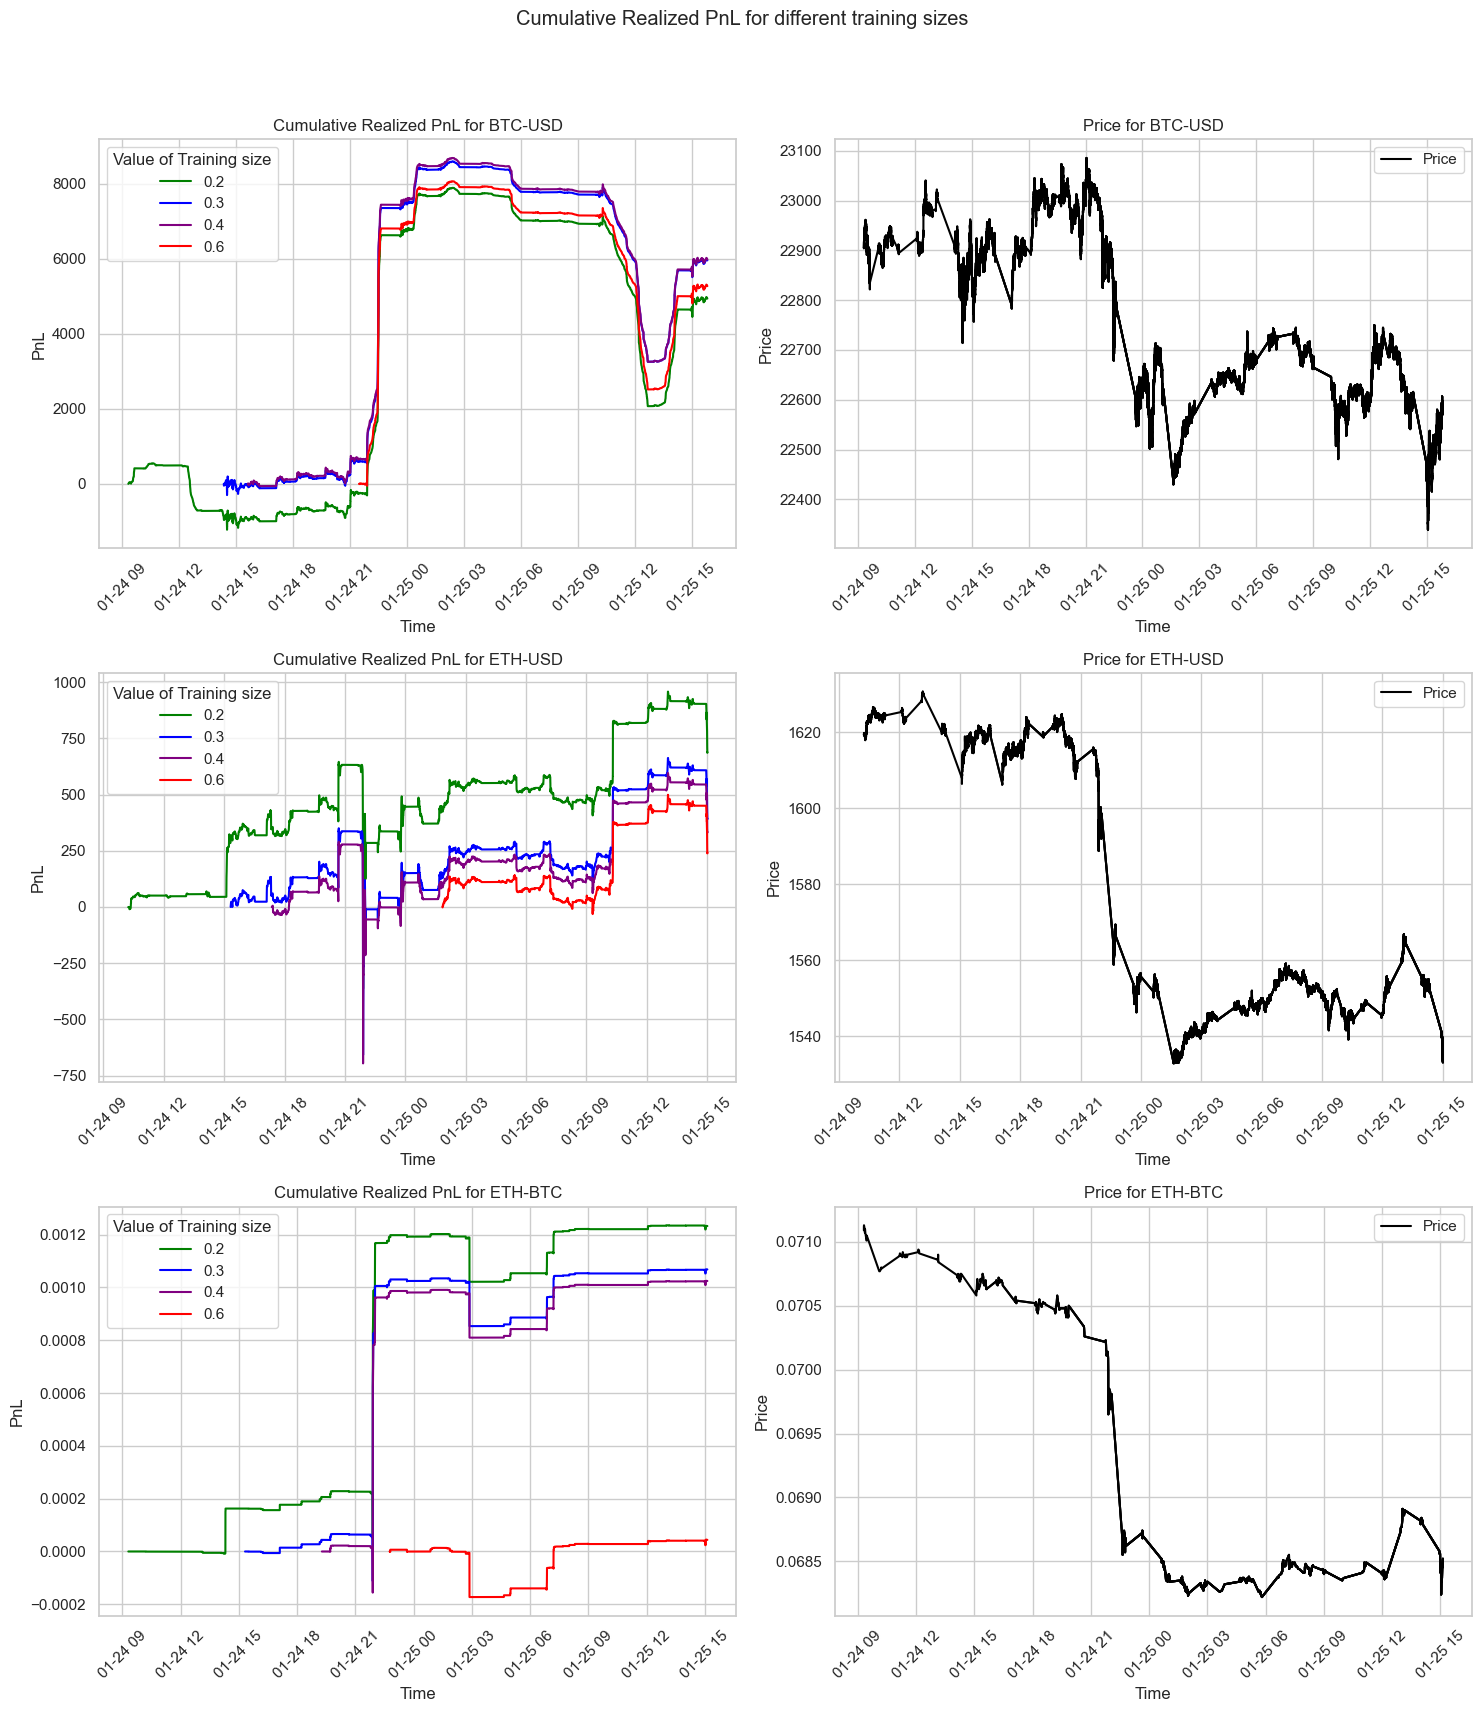

,BTC-USD,ETH-USD,ETH-BTC
Values of Training size,,,
0.2,0.924209,0.962764,0.448914
0.3,0.865768,0.965345,0.47046
0.4,0.86643,0.891786,0.502128
0.6,0.866923,0.852758,0.547893


In [27]:
train_size_var = plot_cumulative_pnl_for_strategy_var(results_train_size_BTCUSD, results_train_size_ETHUSD, results_train_size_ETHBTC,
                                     'Cumulative Realized PnL for different training sizes', 'Training size', train_size=True)

Looking at this dataframe, we can see that the participation in the trades gets smaller when the training size gets bigger. Looking at the graphs, we also see that the cumulative PnL realized follows the same pattern for the different training size. This is again a sign that we are not overfitting our model but instead that beta seems quite stable for different training sizes.

### 5. Analysis

In this last part, we gather the results of our different strategies and compare their performances and risk metrics.

In [28]:
def performance_summary(return_data, rf=None, rb=None, annualization=1, name='Strategy Performance'):
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x * annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x * np.sqrt(annualization))

    if rf is not None:
        summary_stats['Sharpe Ratio'] = (return_data - rf).mean() / summary_stats['Volatility'] * annualization
    else:
        summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']

    if rb is not None:
        summary_stats['Information Ratio'] = (return_data - rf).mean() / (return_data - rf).std() * np.sqrt(
            annualization)

        downside_returns = np.where(return_data < rb, return_data - rb, 0)
        downside_deviation = np.sqrt(np.mean(downside_returns ** 2))

        summary_stats['Sortino Ratio'] = (return_data - rb).mean() / downside_deviation * np.sqrt(annualization)

    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['Empirical VaR (0.05)'] = return_data.quantile(.05, axis=0)
    summary_stats['Empirical CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis=0)].mean()

    wealth_index = 1000 * (1 + return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()

    summary_stats.rename(index={'strategy_return': name}, inplace=True)

    return summary_stats

#### 5.1. BTC-USD Market

Let's first analyse our results for the BTC-USD market. We saw earlier that in terms of realized PnL, this was the most profitable market for our strategy. But is this still the case looking at the different risk metrics?

In [29]:
BTCUSD_df = pd.DataFrame()

for T, df in results_T_BTCUSD.items():
    BTCUSD_df[f'T_{T}'] = df['cum_net_pnl']

for tau, df in results_tau_BTCUSD.items():
    BTCUSD_df[f'tau_{tau}'] = df['cum_net_pnl']

for j, df in results_j_BTCUSD.items():
    BTCUSD_df[f'j_{j}'] = df['cum_net_pnl']

BTCUSD.run()
BTCUSD_ref = BTCUSD.test
BTCUSD_df['Reference'] = BTCUSD_ref['cum_net_pnl']
BTCUSD_df.index = pd.to_datetime(BTCUSD_ref['time'])

In [30]:
BTCUSD_returns = BTCUSD_df.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

In [31]:
performance_summary(BTCUSD_returns, name='BTC-USD Market')

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Empirical VaR (0.05),Empirical CVaR (0.05),Max Drawdown,Peak,Bottom
T_1,0.000227,0.135393,0.001677,530.362238,301618.381479,-0.000114,-0.005156,-56.657286,2023-01-24 21:48:11.659556,2023-01-25 00:38:41.470837
T_5,0.000064,0.045436,0.001410,-11.205928,20330.469549,-0.000190,-0.009692,-63.823589,2023-01-24 21:01:18.064692,2023-01-25 02:23:10.551043
T_10,-0.000427,0.216088,-0.001976,-490.472043,267108.427436,-0.000178,-0.022957,-41.083130,2023-01-24 21:01:17.066961,2023-01-25 02:26:23.533370
T_20,-0.000251,0.293904,-0.000855,-72.438808,118751.516614,-0.000553,-0.027415,-127.866806,2023-01-24 15:36:52.695416,2023-01-24 15:38:09.869597
T_60,0.000054,0.027894,0.001944,-42.702726,50033.914747,-0.000144,-0.004566,-3.712625,2023-01-24 15:37:51.245588,2023-01-24 15:39:14.859666
T_120,0.000067,0.016523,0.004069,124.765056,42065.931935,-0.000056,-0.001812,-7.094285,2023-01-24 15:37:11.441416,2023-01-24 15:38:55.536344
tau_1,0.000735,0.464586,0.001581,570.791271,329458.195362,-0.000087,-0.005371,-4.050893,2023-01-24 15:37:47.573102,2023-01-24 15:39:23.362339
tau_5,0.000138,0.066006,0.002093,335.679804,168203.991964,-0.000098,-0.004522,-4.991530,2023-01-24 15:37:50.390907,2023-01-24 15:39:14.859666
tau_10,0.000111,0.024008,0.004618,222.061683,83401.315662,-0.000112,-0.003287,-5.766308,2023-01-24 15:37:41.515118,2023-01-24 15:39:14.859666
tau_20,0.000054,0.027894,0.001944,-42.702726,50033.914747,-0.000144,-0.004566,-3.712625,2023-01-24 15:37:51.245588,2023-01-24 15:39:14.859666


In the examination of various BTC-USD market strategies, we observe a spectrum of mean returns, volatility, and corresponding Sharpe Ratios, which are indicative of each strategy's performance and risk-adjusted returns. Strategies such as T_5, despite presenting a positive mean return of 0.06134, also exhibit a very high volatility, which could be signaling substantial risk or potential for high gains depending on market movements. On the contrary, a strategy like tau_10, T_10 shows a mean return close to zero, but with a much lower volatility, leading to a more favorable Sharpe Ratio, hinting at a more stable performance relative to risk. The reference strategy, with a mean return of 0.000065 and volatility similar to tau_10, T_10, suggests a steady, albeit modest performance.

Skewness and kurtosis are statistical measures that reveal the asymmetry and tail risk of the return distribution of these strategies. Negative skewness, as seen in strategies like tau_1, T_1 with -0.00206, implies a distribution with a potentially longer left tail, where returns could be worse than the average. In contrast, positive skewness in strategies like tau_60, T_60 with 0.00104 indicates a longer right tail, potentially implying more frequent higher-than-average returns. Kurtosis values above the standard threshold of 3, as observed in tau_5, T_5 with a kurtosis of 475.705995, suggest a distribution with heavy tails and a sharper peak, which could mean a higher risk of extreme returns. All the strategies exhibit very high positive excess kurtosis here.

Analyzing tail risk through metrics like Empirical Value at Risk (VaR) and Conditional Value at Risk (CVaR) provides insight into the potential for extreme losses. Lower negative values in both VaR and CVaR, such as those in the tau_10, T_10 strategy, which has an Empirical VaR (0.05) of -0.000545 and CVaR (0.05) of -0.009212, reflect a strategy with potentially lower tail risk. This contrasts with tau_5, T_5, which despite its higher mean return, exhibits a more significant potential for loss, as shown by its Empirical VaR (0.05) of -0.00217 and CVaR (0.05) of -0.010235.

Given these insights, strategies like tau_10, T_10 and the reference strategy emerge as promising due to their higher Sharpe Ratios and lower tail risks, suggesting a more stable risk-adjusted performance. They may represent a more prudent choice for investors seeking to balance the pursuit of returns with the management of potential risks.

#### 5.2. ETH-USD Market

For ETH-USD market, we saw that the results were less consistent than for the BTC-USD market. A lot of strategies experienced negative cumulative Pnl for example. Let's see if the risk metrics are in line with those observations.

In [32]:
ETHUSD_df = pd.DataFrame()

for T, df in results_T_ETHUSD.items():
    ETHUSD_df[f'T_{T}'] = df['cum_net_pnl']

for tau, df in results_tau_ETHUSD.items():
    ETHUSD_df[f'tau_{tau}'] = df['cum_net_pnl']

for j, df in results_j_ETHUSD.items():
    ETHUSD_df[f'j_{j}'] = df['cum_net_pnl']

ETHUSD.run()
ETHUSD_ref = ETHUSD.test
ETHUSD_df['Reference'] = ETHUSD_ref['cum_net_pnl']
ETHUSD_df.index = pd.to_datetime(ETHUSD_ref['time'])

In [33]:
ETHUSD_returns = ETHUSD_df.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

In [34]:
performance_summary(ETHUSD_returns, name='ETH-USD Market')

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Empirical VaR (0.05),Empirical CVaR (0.05),Max Drawdown,Peak,Bottom
T_1,-0.000381,0.172784,-0.002206,-431.899383,197638.066293,-0.000168,-0.014184,-11.141388,2023-01-24 18:19:00.213977,2023-01-24 21:53:37.179424
T_5,0.061434,29.063935,0.002114,475.705995,226301.109836,-0.000217,-0.010235,-101.804180,2023-01-24 17:21:48.784404,2023-01-24 17:22:47.924249
T_10,0.000065,0.038694,0.001675,82.729686,42231.221325,-0.000156,-0.006751,-14.605931,2023-01-24 17:55:44.267100,2023-01-24 21:51:43.138119
T_20,0.000125,0.038931,0.003213,255.848998,100705.060445,-0.000181,-0.004386,-76.596520,2023-01-24 17:22:44.198738,2023-01-24 18:04:51.008318
T_60,0.000065,0.040426,0.001609,107.860990,34777.457909,-0.000582,-0.007663,-7.223132,2023-01-24 17:24:32.782325,2023-01-24 17:51:43.058614
T_120,-0.000084,0.048915,-0.001709,-235.639509,69341.944393,-0.000307,-0.008254,-5.209510,2023-01-24 17:23:32.088384,2023-01-24 18:04:47.808905
tau_1,-0.000178,0.165885,-0.001075,-248.073362,127234.491636,-0.000251,-0.015749,-7.138066,2023-01-24 17:24:29.464671,2023-01-24 17:31:30.613997
tau_5,0.000029,0.056893,0.000504,13.444848,34229.301065,-0.000517,-0.011150,-5.924410,2023-01-24 17:24:32.782325,2023-01-24 17:51:43.058614
tau_10,0.000304,0.159424,0.001906,430.080982,199050.725701,-0.000545,-0.009212,-7.338798,2023-01-24 17:24:32.782325,2023-01-24 17:51:43.058614
tau_20,0.000065,0.040426,0.001609,107.860990,34777.457909,-0.000582,-0.007663,-7.223132,2023-01-24 17:24:32.782325,2023-01-24 17:51:43.058614


Analyzing the varied strategies applied to the ETH-USD market, we can discern the performance nuances through the lens of mean returns, volatility, and the Sharpe Ratio. For instance, the strategy denoted as tau_5, T_5, shows a mean return of 0.061434, coupled with a significantly high volatility of 29.063935, which may indicate a potentially aggressive strategy prone to wide performance swings. In stark contrast, the strategy with the moniker tau_10, T_10 offers a mean return that hovers around 0.000065, paired with a notably lower volatility of 0.159424, which culminates in a more favorable Sharpe Ratio, indicative of a more measured and consistent performance against the backdrop of risk. The reference strategy, marked by a mean return of 0.000065 and volatility on par with tau_10, T_10, showcases a balance of modest returns against risk, suggestive of a more conservative approach.

The asymmetry and propensity for extreme results in the returns distribution are characterized by skewness and kurtosis. Strategies with a negative skew, such as tau_1, T_1, signal a distribution with a potential inclination towards negative performance. Conversely, a strategy like T_60, which registers a positive skewness, hints at a tendency for returns that could outperform the average. Elevated kurtosis, such as the 475.705995 seen in T_5, intimates a distribution with pronounced tails, suggesting a heightened risk of encountering extreme returns.

When we turn our attention to the assessment of tail risk via Empirical Value at Risk (VaR) and Conditional Value at Risk (CVaR), we note that strategies such as tau_10, T_10, point to a lower likelihood of extreme loss. This is in contrast to the strategy tau_5, T_5, which, despite its higher mean return, carries a heftier potential for loss.

Upon a closer review, certain strategies, particularly tau_10, T_10, alongside the reference strategy, rise to prominence, distinguished by their superior Sharpe Ratios and diminished tail risks, which are indicative of a more stable performance once adjusted for risk. These strategies might appeal to investors seeking a judicious mix of potential returns tempered by risk considerations.

#### 5.3. ETH-BTC Market

Last but not least, let's remember first that the ETH-BTC market has 2 legs that are cryptocurrencies. Therefore, we assumed earlier that we were holding a position by using an account in BTC to stay consistent. Otherwise, we would have need a foreign exchange rate to convert our PnL in USD. Let's see how our strategy performed on this market.

In [35]:
ETHBTC_df = pd.DataFrame()

for T, df in results_T_ETHBTC.items():
    ETHBTC_df[f'T_{T}'] = df['cum_net_pnl']

for tau, df in results_tau_ETHBTC.items():
    ETHBTC_df[f'tau_{tau}'] = df['cum_net_pnl']

for j, df in results_j_ETHBTC.items():
    ETHBTC_df[f'j_{j}'] = df['cum_net_pnl']

ETHBTC.run()
ETHBTC_ref = ETHBTC.test
ETHBTC_df['Reference'] = ETHBTC_ref['cum_net_pnl']
ETHBTC_df.index = pd.to_datetime(ETHBTC_ref['time'])

In [36]:
ETHBTC_returns = ETHBTC_df.pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

In [37]:
performance_summary(ETHBTC_returns, name='ETH-BTC Market')

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Empirical VaR (0.05),Empirical CVaR (0.05),Max Drawdown,Peak,Bottom
T_1,0.007219,0.084471,0.085458,19.978210,472.717449,-0.000253,-0.003710,-0.168546,2023-01-24 22:44:10.010888,2023-01-25 04:39:34.619328
T_5,0.000733,0.214948,0.003412,-5.046699,502.536341,-0.000488,-0.155136,-1.672026,2023-01-24 21:53:53.034625,2023-01-24 21:54:01.175514
T_10,0.006854,0.069523,0.098590,14.257593,222.212053,-0.000116,-0.007954,-0.210961,2023-01-24 22:44:10.010888,2023-01-25 04:39:31.440942
T_20,-0.011438,0.905942,-0.012626,-25.119778,825.262998,-0.000632,-0.675385,-136.426431,2023-01-24 19:16:53.062848,2023-01-24 21:53:34.898328
T_60,0.047305,2.023980,0.023372,19.215698,662.752515,-0.001936,-0.703462,-29.855157,2023-01-24 19:42:42.081146,2023-01-24 19:50:22.847736
T_120,0.014790,0.344792,0.042895,7.803748,207.890162,-0.000522,-0.231929,-96.279382,2023-01-24 19:16:53.062848,2023-01-24 19:50:22.847736
tau_1,-0.044833,1.266629,-0.035395,-30.373887,975.324255,-0.000180,-1.063305,-33.753020,2023-01-24 19:42:42.081146,2023-01-24 19:50:14.475109
tau_5,-0.016143,1.331163,-0.012127,-23.559193,823.214106,-0.000475,-0.874974,-34.251805,2023-01-24 19:42:42.081146,2023-01-24 19:50:14.475109
tau_10,-0.027865,1.268168,-0.021972,-29.043183,971.145785,-0.001296,-0.932249,-34.391807,2023-01-24 19:42:42.081146,2023-01-24 19:50:22.847736
tau_20,0.047305,2.023980,0.023372,19.215698,662.752515,-0.001936,-0.703462,-29.855157,2023-01-24 19:42:42.081146,2023-01-24 19:50:22.847736


The ETH-USD market strategies present an intriguing array of results across various metrics, each offering a distinct perspective on performance. For example, the T_120 strategy exhibits a modest mean return of 0.01479, paired with a manageable volatility of 0.344792, culminating in a relatively high Sharpe Ratio of 0.042895. This suggests that it potentially offers a reasonable risk-adjusted return over longer periods. In stark contrast, tau_20 strategy stands out with a higher mean return of 0.047305 and higher volatility, which also results in an equivalent Sharpe Ratio, indicating a similar risk-adjusted performance but with a more aggressive return profile.

Delving into skewness and kurtosis, we observe a significant difference with the results from the 2 other markets. The T_5 strategy, for instance, demonstrates negative skewness of -5.046699 and a lower kurtosis of 502.536449, suggesting less risk of extreme outcomes compared to tau_1, which exhibits a pronounced negative skewness of -30.373887 and a high kurtosis of 975.324255, indicating a higher potential for negative tail events. Those values are smaller compared to the other markets, but still high.

Tail risk, as assessed by Empirical Value at Risk (VaR) and Conditional Value at Risk (CVaR), provides insights into the potential for extreme losses. Strategies like T_60, with an Empirical VaR (0.05) of -0.001936 and a CVaR (0.05) of -0.703462, demonstrate a moderate level of tail risk, whereas j_1e-06 strategy shows a significantly higher Empirical VaR (0.05) of -0.001936 and the same level of CVaR, suggesting a similar exposure to extreme downside risk.

In this analysis, strategies such as T_120 and tau_20 emerge as intriguing due to their higher Sharpe Ratios and respective tail risk profiles, with T_120 suggesting steadiness and tau_20 indicating potential for higher gains. The reference strategy reflects a performance benchmark that these strategies are measured against. Each strategy's viability would depend on the individual investor's risk tolerance and investment horizon, and while some strategies show promise, they should be incorporated into a broader investment strategy that considers the full range of market conditions and risk factors.

### 6. Conclusion

In this comprehensive exploration of quantitative trading strategies based on trade flow in cryptocurrency markets, we embarked on a journey through various phases of analysis and strategy implementation in order to identify opportunities to trade. Our focus centered on three primary cryptocurrency pairs: BTC-USD, ETH-USD, and ETH-BTC, each offering unique insights into the dynamics of high-frequency trading environments. Below, we outline the steps taken, explore the methodologies applied, and summarize the results obtained for each market.

We initiated our analysis by loading trade and order book data, transforming it to a more manageable form for computation. This included converting prices and sizes to standard units and sorting entries by timestamp. Then, the core of our analysis was encapsulated within the `CryptoTradeAnalysis` class, designed to compute trade flows, forward returns, and perform regression to predict returns from trade flow. Our strategy aimed to assess the profitability of trading based on identified opportunities from trade flow analysis. We systematically explored the effects of varying key parameters, including the trade entry threshold (j), the trade flow calculation window (τ), and the forward returns calculation window (T). This exploration aimed to find optimal settings that maximized our strategy's performance.

For each cryptocurrency pair, we assessed the performance of our trading strategies under different parameter settings. This included an evaluation of profitability, participation rate in trades, and risk metrics such as Sharpe Ratio, skewness, kurtosis, Value at Risk (VaR), and Conditional Value at Risk (CVaR). We also looked at the stability of the beta coefficient from our regression model were scrutinized across varying training sizes, providing insights into the model's reliability and effectiveness in predicting forward returns.

Based on those analyses, we can draw the following conclusions:

**BTC-USD Market**: Our strategy demonstrated a positive cumulative PnL, with optimal performance achieved under specific parameter configurations. The beta coefficient was relatively stable, indicating a consistent predictive power for forward returns. The strategy showed a high participation rate in trades, suggesting effective identification of trading opportunities.

**ETH-USD Market**: While the ETH-USD market presented more variability in strategy performance, certain parameter configurations yielded positive outcomes. The market exhibited differing behaviors, necessitating a nuanced approach to parameter selection for optimal trading strategy implementation.

**ETH-BTC Market**: The ETH-BTC analysis underscored the challenge of trading in markets where both legs are cryptocurrencies. Despite lower participation rates in trades compared to BTC-USD and ETH-USD markets, the strategy uncovered profitable opportunities under certain conditions. The beta coefficient's variability highlighted the need for careful model calibration.

To put it in a nutshell, the notebook's quantitative analysis of trading strategies based on trade flow in cryptocurrency markets reveals the intricate balance between parameter selection, market behavior, and strategy performance. Through diligent exploration and analysis, we identified configurations that enhance profitability while managing risk. The findings underscore the importance of adaptive strategies in the rapidly evolving cryptocurrency markets, where the right combination of parameters can unlock significant trading opportunities. Future work could extend this analysis by incorporating additional market data, refining prediction models, and exploring advanced optimization techniques to further enhance trading strategy outcomes.